### Kaggle: HR Analytics Job Change of Data Scientists

#### BACKGROUND
    Written by: Elektra Neocleous
    Created: 3/1/2021
    Last modifed: 20/3/2021
    Objective: To predict the probability of a candidate to look for a new job or will work for the company, 
    as well as interpreting affected factors on employee decision.
    Kaggle:  https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

#### Kaggle Context and Content

A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses which conduct by the company. Many people signup for their training. Company wants to know which of these candidates are really wants to work for the company after training or looking for a new employment because it helps to reduce the cost and time as well as the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience are in hands from candidates signup and enrollment.

This dataset designed to understand the factors that lead a person to leave current job for HR researches too. By model(s) that uses the current credentials,demographics,experience data you will predict the probability of a candidate to look for a new job or will work for the company, as well as interpreting affected factors on employee decision.

The whole data divided to train and test . Target isn't included in test but the test target values data file is in hands for related tasks. A sample submission correspond to enrollee_id of test set provided too with columns : enrollee _id , target

Note:

* The dataset is imbalanced.
* Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.
* Missing imputation can be a part of your pipeline as well.

#### TABLE OF CONTENTS

0. Import and Explore
1. Pre-Process
    * a. Handling Nulls
    * b. Encoding categorical data
    * c. Test train split 
        * i. Raw data without an imbalance resolution
        * ii. Resolve imbalance with Smote - Synthetic Minority Oversampling Technique
2. Model

    * a. Logistic Regression
        * i. Train the model
        * ii. Score the model
        * iii. Performance metrics

    * b. Random Forest
        * i. Train the model
        * ii. Feature Importance

    * c. Light GBM
        * i. Train the model
        * ii. Score the model
        * ii. Performance metrics

In [282]:
#base packages
import pandas as pd
import numpy as np

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#pre-processing and data transformations
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import copy
from sklearn.model_selection import train_test_split
from collections import Counter

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

#performance metrics
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, precision_score, recall_score, f1_score, cohen_kappa_score
from category_encoders.ordinal import OrdinalEncoder
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import DiscriminationThreshold, ROCAUC, confusion_matrix
import shap
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve

### 0. Import and Explore

In [168]:
aug_test = pd.read_csv("data/aug_test.csv")
aug_train = pd.read_csv("data/aug_train.csv")

In [169]:
aug_test.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [170]:
aug_test.shape

(2129, 13)

In [171]:
aug_train.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [172]:
aug_train.shape

(19158, 14)

Explore the target to understand the noted imbalance

Target Variable:
<br>

**0 – Not looking for job change
<br>
1 – Looking for a job change**

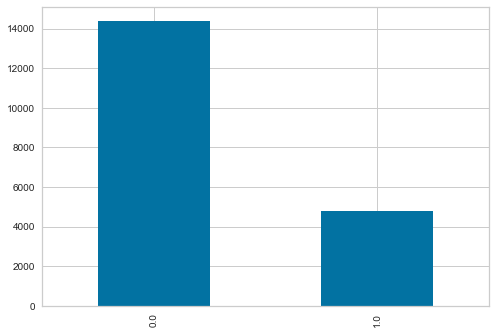

In [173]:
pd.value_counts(aug_train['target']).plot.bar()

### 1. Pre-Process

In [174]:
#create a copy incase we would like to backtrack
df_train=copy.deepcopy(aug_train)
df_test=copy.deepcopy(aug_test)

**a. Handling Nulls** <br>
Our length of the dataset is 21k rows, there is a substantial amount of values missing. To handle the this we can drop the rows missing information and still have a substantial amount of rows to model on.

In [175]:
df_train.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [176]:
df_test.isna().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

In [177]:
df_train = df_train.dropna() #drop our na's as theres sufficient rows to fill in the gaps
df_test = df_test.dropna()

In [178]:
df_train.shape

(8955, 14)

In [179]:
df_test.shape

(1019, 13)

**b. Encoding categorical data** <br>
Our samples above show that there is categorical data in the columns, we will need to encode these to allow the model to handle the input sufficiently. 

In [180]:
#Objects show us that these are categorical, floats and ints are ok
df_train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [181]:
#Show all the different unique values in every column so we can get an 
#understanding of what needs to be encoded
for col in df_train:
    print(df_train[col].unique())

[29725   666   402 ... 32313 29754 24576]
['city_40' 'city_162' 'city_46' 'city_103' 'city_61' 'city_114' 'city_159'
 'city_21' 'city_160' 'city_16' 'city_83' 'city_64' 'city_105' 'city_104'
 'city_73' 'city_75' 'city_100' 'city_93' 'city_67' 'city_13' 'city_36'
 'city_71' 'city_57' 'city_65' 'city_11' 'city_136' 'city_97' 'city_50'
 'city_173' 'city_82' 'city_89' 'city_150' 'city_90' 'city_98' 'city_28'
 'city_115' 'city_94' 'city_165' 'city_142' 'city_12' 'city_43' 'city_74'
 'city_102' 'city_116' 'city_99' 'city_23' 'city_138' 'city_45' 'city_41'
 'city_72' 'city_19' 'city_101' 'city_20' 'city_106' 'city_10' 'city_157'
 'city_144' 'city_91' 'city_133' 'city_145' 'city_123' 'city_175'
 'city_128' 'city_167' 'city_84' 'city_54' 'city_126' 'city_81' 'city_176'
 'city_131' 'city_149' 'city_24' 'city_27' 'city_118' 'city_152'
 'city_141' 'city_76' 'city_70' 'city_143' 'city_78' 'city_53' 'city_158'
 'city_2' 'city_77' 'city_117' 'city_120' 'city_9' 'city_39' 'city_80'
 'city_155' 'city_1

In [182]:
#Pick out our object data types, confirmed by the above sample that need to be encoded
le = LabelEncoder()
df_train['gender'] = le.fit_transform(df_train['gender'])
df_train['relevent_experience'] = le.fit_transform(df_train['relevent_experience'])
df_train['enrolled_university'] = le.fit_transform(df_train['enrolled_university'])
df_train['education_level'] = le.fit_transform(df_train['education_level'])
df_train['major_discipline'] = le.fit_transform(df_train['major_discipline'])
df_train['experience'] = le.fit_transform(df_train['experience'])
df_train['company_size'] = le.fit_transform(df_train['company_size'])
df_train['company_type'] = le.fit_transform(df_train['company_type'])
df_train['last_new_job'] = le.fit_transform(df_train['last_new_job'])
df_test['gender'] = le.fit_transform(df_test['gender'])
df_test['relevent_experience'] = le.fit_transform(df_test['relevent_experience'])
df_test['enrolled_university'] = le.fit_transform(df_test['enrolled_university'])
df_test['education_level'] = le.fit_transform(df_test['education_level'])
df_test['major_discipline'] = le.fit_transform(df_test['major_discipline'])
df_test['experience'] = le.fit_transform(df_test['experience'])
df_test['company_size'] = le.fit_transform(df_test['company_size'])
df_test['company_type'] = le.fit_transform(df_test['company_type'])
df_test['last_new_job'] = le.fit_transform(df_test['last_new_job'])

In [183]:
#We can see our encoding worked nicely, giving each unique categorical a numeric number
df_test.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
3,27385,city_13,0.827,1,0,2,1,5,2,0,5,0,39
4,27724,city_103,0.920,1,0,2,0,5,21,3,5,4,72
11,9272,city_90,0.698,1,0,2,0,5,12,0,5,1,51
12,14249,city_46,0.762,1,0,2,0,5,18,1,3,5,48
16,7865,city_21,0.624,1,0,2,1,5,14,1,5,0,4


In [184]:
#This looks good as we dont have any objects in our label file left, our models will be able to handle numeric data much better
df_test.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                      int32
relevent_experience         int32
enrolled_university         int32
education_level             int32
major_discipline            int32
experience                  int32
company_size                int32
company_type                int32
last_new_job                int32
training_hours              int64
dtype: object

**c. Test train split** <br>

**i. Raw data without an imbalance resolution** <br>

In [215]:
#we are going to split the train data set given down into test train split
#the test data set given to us without target will be used to score on later on
test = df_test.copy()
train = df_train.copy()

def to_xy(df):
    df = df.drop(['enrollee_id','city'],axis=1)
    x = df.drop(['target'], axis=1)
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

In [216]:
X_train, X_test, y_train, y_test = to_xy(train)

In [218]:
print(X_train.shape)
print(X_test.shape)
print(X_test.dtypes)
print(y_train.shape)
print(y_test.shape)

(5999, 11)
(2956, 11)
city_development_index    float64
gender                      int32
relevent_experience         int32
enrolled_university         int32
education_level             int32
major_discipline            int32
experience                  int32
company_size                int32
company_type                int32
last_new_job                int32
training_hours              int64
dtype: object
(5999,)
(2956,)


**ii. Resolve imbalance with Smote - Synthetic Minority Oversampling Technique**<br>
We learnt above between our targets our 0's highly outweigh our 1's. This is common in datasets as our 1's can be a smaller population of unique attributes. We can solver this by either over or under sampling the populations: <br>
* Undersampling would decrease the proportion of your majority class until the number is similar to the minority class.
* Oversampling would resample the minority class proportion following the majority class proportion. e.g. SMOTE, repetition or bootstrapping.

In [230]:
#We can make a copy of this dataset without the primary keys of id and city as these aren't features
test = df_test.copy()
train = df_train.copy()
test = test.drop(['enrollee_id','city'],axis=1)
train = train.drop(['enrollee_id','city'],axis=1)

**i. Smote - Synthetic Minority Oversampling Technique** <br>
The SMOTE algorithm can be broken down into four steps: <br>

* Randomly pick a point from the minority class.
* Compute the k-nearest neighbors (for some pre-specified k) for this point.
* Add k new points somewhere between the chosen point and each of its neighbors.

In [231]:
#Seperate the target column from the training dataset and place them into their
#respective x and y so we can apply the technique to them

def smote():
    X=train.drop(columns=['target']).values #we remove the target off our file and place it into its own variable
    y=train['target'].values
    print('Before resampled dataset shape %s' % Counter(y))
    
    #Apply smote then create our test and train split
    smote = SMOTE(random_state=0)
    X, y = smote.fit_sample(X, y) #fit our smote to the x and y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)
    print('Resampled dataset shape %s' % Counter(y))
    
    #Convert x and y back to dataframe from the numpy array output of smote
    X = pd.DataFrame(X, columns = ['city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours'])
    df_y = pd.DataFrame(y, columns = ['target'])
    
    df_oversampler_concat = pd.merge(X, df_y, left_index=True, right_index=True)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)
    print('Resampled dataset shape %s' % Counter(y))
    
    #plot the new dataframe with the over sampled target
    #let's understand the different behaviour of 0 and 1's to different features
   
    cols_to_plot = ['city_development_index','major_discipline']
    
    fig, ax = plt.subplots(nrows=len(cols_to_plot), ncols=1, figsize=(8,8))
    for i, col in enumerate(cols_to_plot):
        plt.subplot(ax[i])
        sns.scatterplot(x=df_oversampler_concat[col], y=df_oversampler_concat['target'], hue = df_oversampler_concat['target'])
        plt.ylabel(col)
        plt.tight_layout()

    return X_train, X_test, y_train, y_test, df_oversampler

Before resampled dataset shape Counter({0.0: 7472, 1.0: 1483})
Resampled dataset shape Counter({0.0: 7472, 1.0: 7472})
Resampled dataset shape Counter({0.0: 7472, 1.0: 7472})


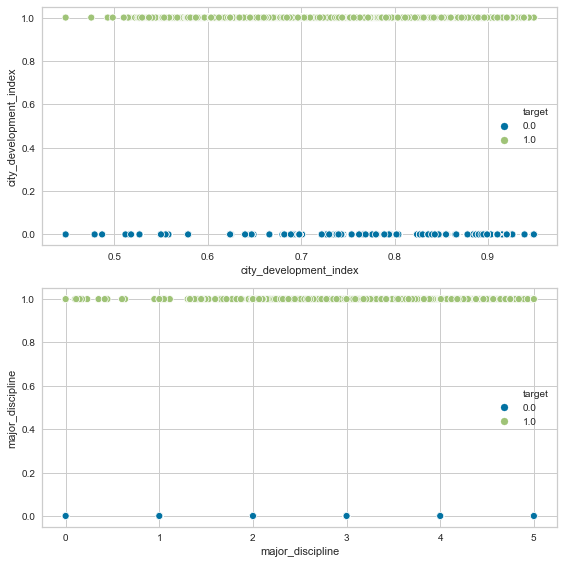

In [232]:
#Now even though the dots between orange and blue may be different, these scatterplots are just showing us the different
#data points the 0 or 1 can have, not the total data points

#City development index: shows that 1's have a larger range of cities, where 0's has less
X_train, X_test, y_train, y_test, df_oversampler = smote()

In [233]:
print(X_train.shape)
print(X_test.shape)
print(X_test.dtypes)
print(y_train.shape)
print(y_test.shape)

(10012, 11)
(4932, 11)
city_development_index    float64
gender                    float64
relevent_experience       float64
enrolled_university       float64
education_level           float64
major_discipline          float64
experience                float64
company_size              float64
company_type              float64
last_new_job              float64
training_hours            float64
dtype: object
(10012,)
(4932,)


## 2. Model

Play around with a few different models, tune different hyperparametres to see which one works well

### a. Logistic Regression
Logistic regression models the probabilities for classification problems with two possible outcomes, 0 or 1. It uses logarithm of the odds for the value labelled as 1 to calculate the probabilities and predict the occurance of the event being this label. Logistic regression is statistical, relatively fast and uncomplicated for binary classification problems. 

**a. i. Train the model**

In [265]:
#basic logistic regression model
logistic = LogisticRegression(max_iter=10000) #max_iter increased due to convergence warning
logistic.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

**a. ii. Score the model**

In [269]:
#the probabilities for each row
y_prob_logistic = logistic.predict_proba(X_test)

In [270]:
y_prob_logistic

array([[0.47760923, 0.52239077],
       [0.18986294, 0.81013706],
       [0.72076557, 0.27923443],
       ...,
       [0.12805055, 0.87194945],
       [0.10009303, 0.89990697],
       [0.74458431, 0.25541569]])

(0.0, 1.0)

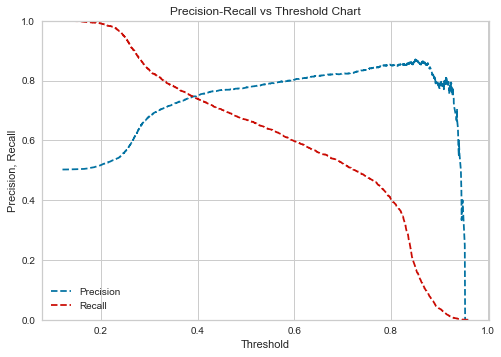

In [271]:
#the default threshold for a prediction is 0.5, however if we plot the relationship between the precision, recall
#and the threshold we can continue to manage any left over imbalances from smote by adjusting the threshold

precision, recall, thresholds = precision_recall_curve(y_test, y_prob_logistic[:, 1]) 

#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [272]:
#the predictions for each row based on the 0.39 tr from the above viz
y_pred_logistic = (logistic.predict_proba(X_test)[:,1]>= 0.39).astype(bool)

In [273]:
y_pred_logistic

array([ True,  True, False, ...,  True,  True, False])

**a. iii. Performance metrics**

**Accuracy**<br>
Accuracy = (TP+TN)/(TP+FP+FN+TN)<br>
Accuracy is a valid choice of evaluation for classification problems which are well balanced and not skewed or No class imbalance. We know we had an imbalanced dataset which was fixed in pre-processing so this score would be higher if performed on an un-preproccessed dataset

In [266]:
#Accuracy or AUC calc
# Use score method to get accuracy of model
score = logistic.score(X_test,y_test)
print('Accuracy on test set is : ',round(score, 2))

Accuracy on test set is :  0.74


**Confusion Matrix**<br>
A table that clearly identifies the counts of True Positives, False Positives, False Negatives and True Negatives. From these raw numbers we can calculate further metrics to grasp the strengths and weaknesses of the model.

In [268]:
#Make predictions on entire test data
predictions = logistic.predict(X_test) 

#Prepare a confusion matrix from the predictions on the entire data set
#Confusion matrix positionings: https://glassboxmedicine.files.wordpress.com/2019/02/confusion-matrix.png?w=816
cm = metrics.confusion_matrix(y_test, predictions)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[0][1]
print('True Positive: %.f, False Positive: %.f, False Negative: %.f, True Negative %.f' % (tp, fp, fn, tn))

True Positive: 1977, False Positive: 477, False Negative: 819, True Negative 477


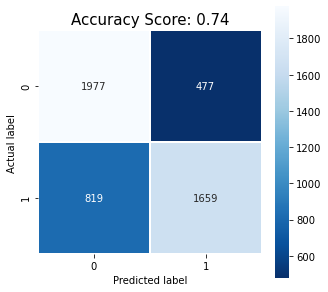

In [40]:
#Annotate all of our information into a plot
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(score, 2))
plt.title(all_sample_title, size = 15);

**Area under the curve (ROC)** <br>
A ROC curve is constructed by plotting the true positive rate (TPR) against the false positive rate (FPR). The true positive rate is the proportion of observations that were correctly predicted to be positive out of all positive observations (TP/(TP + FN)). 

*Interpretation* <br>
Curves closer to the top left of the graph, indicate a better performance. Closer the curve comes along the red dotted line, the less accurate the test. We see below that we did well, there may be some room for improvement for our 477 false positives and 819 false negatives.

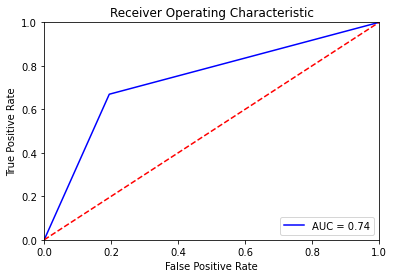

In [41]:
#Area under the curve
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**GINI Coefficient** <br>
The gini measures inequality among values of a variable and the overall performance of the classifier. It is good when used on imbalanced datasets, a score closer to 1 would be better but depending on the classifier there will be limitations on how close to 1 it can get. We could do better here, 49% is average.

In [275]:
#print metrics
print('\n Classification report:\n', classification_report(y_test, y_pred_logistic))
print('\n GINI :\n', 2* roc_auc_score(y_test, y_pred_logistic) -1)
print('\n Precision:\n', precision_score(y_test, y_pred_logistic))
print('\n Recall:\n', recall_score(y_test, y_pred_logistic))
print('\n F1 score:\n', f1_score(y_test, y_pred_logistic))
print('\n Cohen Kappa Score:\n', cohen_kappa_score(y_test, y_pred_logistic))


 Classification report:
               precision    recall  f1-score   support

         0.0       0.74      0.74      0.74      2454
         1.0       0.75      0.75      0.75      2478

    accuracy                           0.75      4932
   macro avg       0.75      0.75      0.75      4932
weighted avg       0.75      0.75      0.75      4932


 GINI :
 0.4906571471985255

 Precision:
 0.7463709677419355

 Recall:
 0.7469733656174334

 F1 score:
 0.7466720451795078

 Cohen Kappa Score:
 0.4906590836883743


**Feature Importance**

In [308]:
logistic_coefs = np.abs(logistic.coef_[0])
logistic_indices = np.argsort(logistic_coefs)[::-1]

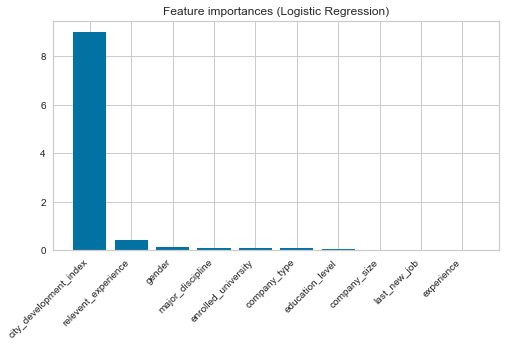

In [316]:
plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(10), logistic_coefs[logistic_indices[:10]], align="center")
plt.xticks(range(10), X_train.columns[logistic_indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

### b. Random Forest

**b. i. Train the model**

In [283]:
#lets do some hyperparameter tuning of a random forest, by for looping through and finding the bst depth and size of our trees
best_acc = 0.0
best_size = 0
best_depth = 0

for depth in [8,9,10]:
    for size in [40,60,80]:
        clf = RandomForestClassifier(n_estimators=size, max_depth=depth, n_jobs=6)
        scores = cross_val_score(clf, X_train, y_train, cv=3)
        acc = scores.mean()
        print ("size", size, ", depth:", depth, "acc:", acc)
        if acc > best_acc:
            best_acc = acc
            best_size = size
            best_depth = depth
    print ("best size", best_size, ", best depth:", best_depth, "best acc", best_acc)
    clf = RandomForestClassifier(n_estimators=best_size, max_depth=best_depth, n_jobs=6)
    clf.fit(X_train,y_train)

size 40 , depth: 8 acc: 0.8521783617409705
size 60 , depth: 8 acc: 0.8511792809814537
size 80 , depth: 8 acc: 0.8503804592659279
best size 40 , best depth: 8 best acc 0.8521783617409705
size 40 , depth: 9 acc: 0.858370890881624
size 60 , depth: 9 acc: 0.8592699618197095
size 80 , depth: 9 acc: 0.8591701913994066
best size 60 , best depth: 9 best acc 0.8592699618197095
size 40 , depth: 10 acc: 0.8664612126181871
size 60 , depth: 10 acc: 0.8662612229004655
size 80 , depth: 10 acc: 0.8672604532856877
best size 80 , best depth: 10 best acc 0.8672604532856877


**b. ii. Feature Importance**

In [285]:
#turn x_train from array to df
df = pd.DataFrame(X_train, columns = ['city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours'])

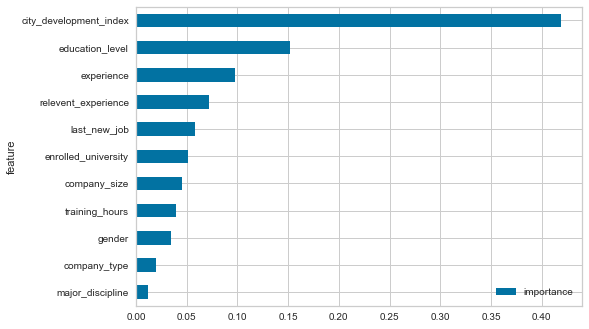

In [307]:
#Now use our dataframe and line it up with the importances determined by our random forest

#We learn here, the features that have a strong influence on our candiate looking for a new job would be their
#city which makes sense as you move cities you would like to work close by, if the candiate takes further education
#they may want to allign their career to that and as experience increases they may feel confident to embark into other roles.

#Objective recap:
#To predict the probability of a candidate to look for a new job or will work for the company, as well as interpreting affected factors on employee decision.

importances = pd.DataFrame({'feature':df.columns,'importance':np.round(clf.feature_importances_,3)})
importances.sort_values(by=['importance'], ascending=True).plot.barh(x='feature', y='importance')

### c. Light GBM

**c. i. Train the model**

In [234]:
model = Pipeline( 
    steps=[
        ('encoder', OrdinalEncoder()),
        ('classifier', lgb.LGBMClassifier(random_state=42, n_jobs=-1))

        ],
    verbose=True
)

model

Pipeline(steps=[('encoder', OrdinalEncoder()),
                ('classifier', LGBMClassifier(random_state=42))],
         verbose=True)

In [235]:
%%time 
#X_train, X_test, y_train, y_test,
cross_val_score(
    estimator=model,
    X=X_train,
    y=y_train,
    cv=TimeSeriesSplit(n_splits=5, max_train_size=None),
    verbose=True,
    scoring='roc_auc'
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
Wall time: 734 ms


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


array([0.93098376, 0.94543154, 0.9535046 , 0.95321581, 0.95589507])

[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s


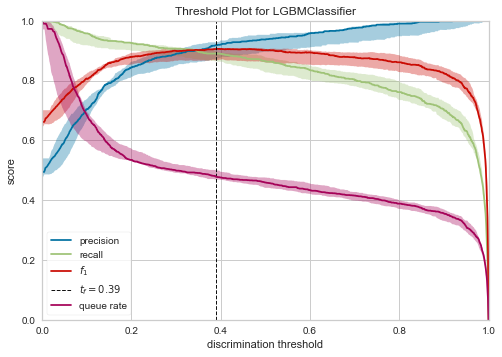

In [236]:
visualizer_xgboost = DiscriminationThreshold(model, random_state=42, n_trials=1, verbose=1, cv=TimeSeriesSplit
                                            (n_splits=5, max_train_size=None))
visualizer_xgboost.fit(X_train, y_train)
visualizer_xgboost.poof()

In [237]:
model.fit(X=X_train, y=y_train)

[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s


Pipeline(steps=[('encoder', OrdinalEncoder(cols=[], mapping=[])),
                ('classifier', LGBMClassifier(random_state=42))],
         verbose=True)

**c. ii. Score the model**

In [251]:
#the predictions for each row based on the 0.39 tr from the above viz
y_pred_bt = (model.predict_proba(X_test)[:,1]>= 0.39).astype(bool)

In [252]:
#the probabilities for each row
y_prob_bt = model.predict_proba(X_test)

In [253]:
y_pred_bt

array([False,  True, False, ...,  True,  True, False])

In [254]:
y_prob_bt[:, 1] #only the first column in the array

array([0.07681258, 0.92173302, 0.26890563, ..., 0.9958342 , 0.99810734,
       0.07794503])

In [255]:
#now join back the predictions to the dataframe as the score for each row
test_data_scores = pd.DataFrame(data=y_pred_bt, columns=["Score"])

In [256]:
test_data_scores_all = pd.concat([X_test.reset_index(drop=True), test_data_scores.reset_index(drop=True)], axis=1)
test_data_scores_all.tail(2)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,Score
4930,0.567069,1.0,0.0,0.837219,0.837219,5.0,11.0,3.162781,5.0,0.162781,68.837219,True
4931,0.910000,2.0,0.0,2.000000,0.000000,5.0,6.0,3.000000,5.0,0.000000,53.000000,False


In [257]:
#target out come break down, how many rows were predicted what
test_data_scores_all["Score"].value_counts()

False    2501
True     2431
Name: Score, dtype: int64

**c. ii. Performance metrics**

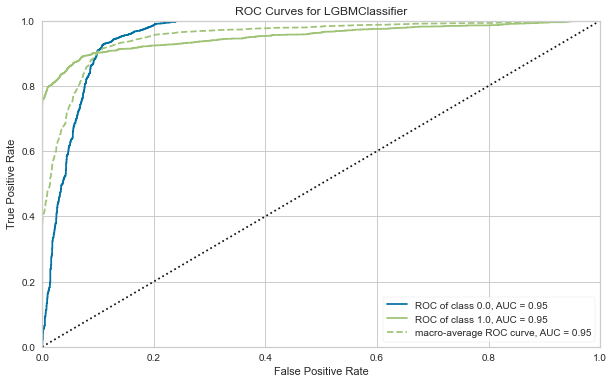

In [258]:
#plot a roc curve to understand the relationship between TP and FP
#accuracy is abit higher than expected
plt.figure(figsize=(10,6))
visualiser_roc_curve = ROCAUC(model, per_class=True, micro=False)
visualiser_roc_curve.fit(X_train, y_train) #Fit the training data to the visualiser
visualiser_roc_curve.score(X_test, y_test) #Evaluate them model on test data
visualiser_roc_curve.show()

In [259]:
#print metrics
print('\n Classification report:\n', classification_report(y_test, y_pred_bt))
print('\n GINI :\n', 2* roc_auc_score(y_test, y_pred_bt) -1)
print('\n Precision:\n', precision_score(y_test, y_pred_bt))
print('\n Recall:\n', recall_score(y_test, y_pred_bt))
print('\n F1 score:\n', f1_score(y_test, y_pred_bt))
print('\n Cohen Kappa Score:\n', cohen_kappa_score(y_test, y_pred_bt))


 Classification report:
               precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      2454
         1.0       0.91      0.90      0.90      2478

    accuracy                           0.90      4932
   macro avg       0.90      0.90      0.90      4932
weighted avg       0.90      0.90      0.90      4932


 GINI :
 0.8090906579365409

 Precision:
 0.9127930892636775

 Recall:
 0.8954802259887006

 F1 score:
 0.9040537787736809

 Cohen Kappa Score:
 0.809015623581782


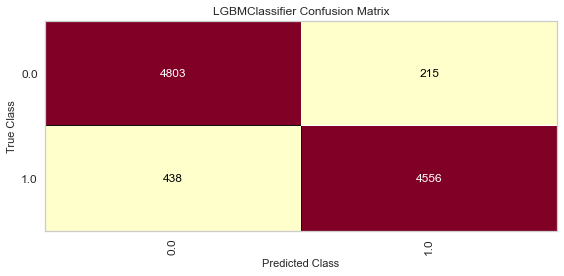

In [260]:
#confusion matrix
plt.figure(figsize=(8,4))
confusion_matrix(
    model,
    X_train, y_train, X_test)
plt.show()

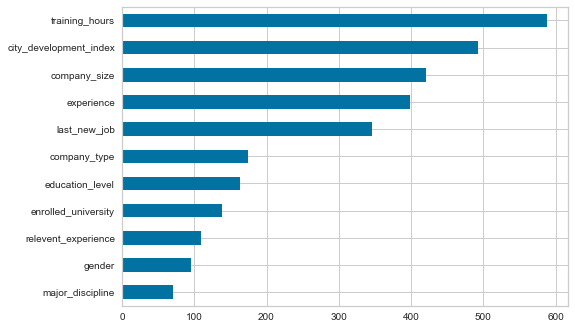

In [261]:
#for the entire dataset, what features contributed to the outcome?
feat_importances = pd.Series(model.steps[-1][-1].feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).sort_values(ascending=True).plot(kind ='barh')

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


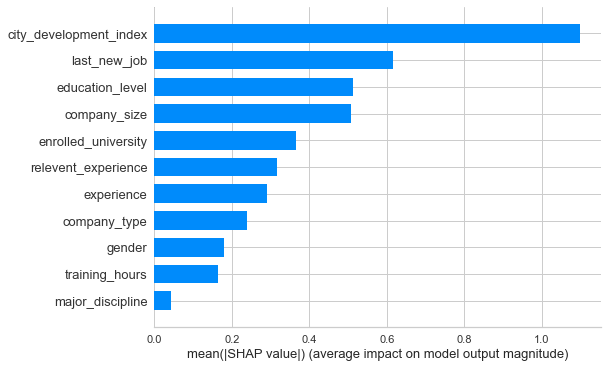

In [262]:
#for the rows that were predicted 1 or true, what features contributed to them the most?
explainer = shap.TreeExplainer(model[-1])
X_test_tr = model[0].transform(X_test)
X_test_tr = pd.DataFrame(data=X_test_tr, index=X_test.index, columns=X_test.columns)

shap_values = explainer.shap_values(X_test_tr)
class_id = 1
shap.summary_plot(shap_values[class_id ], X_test, plot_type="bar")